In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.fft import fft, ifft, fftfreq
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
from pandas.tseries.offsets import MonthBegin
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Hard-Coded Variables 
- uses domain knowledge 

In [2]:
#hardcoded information
expected_groups = {
    ('A', 7),
    ('A', 8),
    ('B', 1),
    ('B', 2),
    ('C', 3),
    ('C', 4),
    ('D', 5),
    ('D', 6),
}

group_1 = {1,2,7,8}
group_2 = {3,4,5,6}
group_1_feature_bounds = {
    "wheeldiameter": (29.0, 41),
    "wheelwidth": (5.50, 5.9),
    "flangeheight": (0.90, 1.55),
    "flangethickness": (0.85, 1.75),
    "flangeslope": (0.10, 0.60),
    "treadhollow": (0.01, 5.3),
    "rimthickness": (0.75, 1.85),
    "backtobackgauge": (52.0, 53.0),
}
group_2_feature_bounds = {
    "wheeldiameter": (29.0, 46.0),
    "wheelwidth": (5.50, 5.87),
    "flangeheight": (0.90, 1.55),
    "flangethickness": (0.85, 1.75),
    "flangeslope": (0.10, 0.60),
    "treadhollow": (0.01, 5.1),
    "rimthickness": (0.80, 2.1),
    "backtobackgauge": (52.0, 53.0),
}

group_2_severity_thresholds = {'backtobackgauge': [(52.0, -5), (52.0, -4), (52.0, -3), (52.0, -2), (52.0, -1),
                     (53.0, 1), (53.0, 2), (53.0, 3), (53.0, 4), (53.0, 5)],
 'flangeheight': [(1.009, -5), (1.027, -4), (1.036, -3), (1.041, -2),
                  (1.057, -1), (1.467, 1), (1.487, 2), (1.492, 3), (1.5, 4),
                  (1.508, 5)],
 'flangeslope': [(0.119, -5), (0.122, -4), (0.124, -3), (0.126, -2),
                 (0.132, -1), (0.505, 1), (0.528, 2), (0.535, 3), (0.544, 4),
                 (0.556, 5)],
 'flangethickness': [(0.878, -5), (0.897, -4), (0.911, -3), (0.924, -2),
                     (0.969, -1), (1.544, 1), (1.572, 2), (1.582, 3),
                     (1.597, 4), (1.62, 5)],
 'rimthickness': [(0.852, -5), (0.868, -4), (0.88, -3), (0.889, -2), (0.92, -1),
                  (1.983, 1), (2.012, 2), (2.021, 3), (2.032, 4), (2.05, 5)],
 'treadhollow': [(0.01, -5), (0.01, -4), (0.01, -3), (0.01, -2), (0.01, -1),
                 (4.029, 1), (4.369, 2), (4.473, 3), (4.601, 4), (4.769, 5)],
 'wheeldiameter': [(29.0, -5), (29.134, -4), (30.0, -3), (30.63, -2),
                   (32.756, -1), (43.622, 1), (44.331, 2), (44.488, 3),
                   (44.724, 4), (45.118, 5)],
 'wheelwidth': [(5.516, -5), (5.526, -4), (5.533, -3), (5.539, -2), (5.554, -1),
                (5.812, 1), (5.831, 2), (5.837, 3), (5.843, 4), (5.852, 5)]}

group_1_severity_thresholds = {
    'backtobackgauge': [(52.0, -5), (52.0, -4), (52.0, -3), (52.0, -2), (52.0, -1),
                     (53.0, 1), (53.0, 2), (53.0, 3), (53.0, 4), (53.0, 5)],
 'flangeheight': [(1.03, -5), (1.044, -4), (1.051, -3), (1.058, -2),
                  (1.072, -1), (1.5, 1), (1.515, 2), (1.52, 3), (1.525, 4),
                  (1.533, 5)],
 'flangeslope': [(0.124, -5), (0.128, -4), (0.13, -3), (0.132, -2), (0.139, -1),
                 (0.52, 1), (0.543, 2), (0.55, 3), (0.559, 4), (0.572, 5)],
 'flangethickness': [(0.879, -5), (0.895, -4), (0.909, -3), (0.92, -2),
                     (0.96, -1), (1.575, 1), (1.604, 2), (1.615, 3), (1.63, 4),
                     (1.653, 5)],
 'rimthickness': [(0.778, -5), (0.796, -4), (0.81, -3), (0.822, -2),
                  (0.866, -1), (1.694, 1), (1.726, 2), (1.736, 3), (1.749, 4),
                  (1.768, 5)],
 'treadhollow': [(0.01, -5), (0.01, -4), (0.01, -3), (0.01, -2), (0.01, -1),
                 (4.196, 1), (4.53, 2), (4.636, 3), (4.757, 4), (4.938, 5)],
 'wheeldiameter': [(30.394, -5), (30.709, -4), (30.945, -3), (31.102, -2),
                   (31.575, -1), (38.976, 1), (39.528, 2), (39.764, 3),
                   (40.0, 4), (40.236, 5)],
 'wheelwidth': [(5.527, -5), (5.537, -4), (5.543, -3), (5.548, -2), (5.563, -1),
                (5.812, 1), (5.833, 2), (5.839, 3), (5.845, 4), (5.853, 5)]
}

geometry_features = ['flangeheight', 'rimthickness', 'wheeldiameter', 'wheelwidth','flangethickness','flangeslope', 'backtobackgauge','treadhollow', 'flangeangle']  


## Initializations
- loading datasets
- filtering invalid values and axles
- merging failure dfs into one

In [3]:
# Functions
def load_data(path_prefix: str = '../Datasets') -> dict:
    """
    Load all required datasets and fill missing failure reasons.
    Returns a dict of DataFrames.
    """
    files = {
        'failure': 'FailureTable0723.csv',
        'equipment': 'equipment_data_masked.csv',
        'mileage': 'Mileage0723.csv',
        'wpd': 'Wpd0723.csv',
    }
    dfs = {name: pd.read_csv(f"{path_prefix}/{fname}", engine='pyarrow') for name, fname in files.items()}
    dfs['failure']['failurereason'] = dfs['failure']['failurereason'].fillna('not failed')
    dfs['wpd']= dfs['wpd'][dfs['wpd']['traindate'] < '2024-12-01']
    return dfs



In [4]:
# merge with failurereason, and applieddate and mileage data
def fast_filter(df, name,valid_axles, feature_bounds):
    before = df.shape
    valid_trucks = {(truck) for (truck, axle) in expected_groups if axle in valid_axles}
    valid_pairs = {(truck, axle) for (truck, axle) in expected_groups if axle in valid_axles}

    if 'axle' not in df.columns:
        mask = df['truck'].isin(valid_trucks)
    else:
        mask = [pair in valid_pairs for pair in zip(df['truck'], df['axle'])]

    df_filtered = df[mask].copy()
    df_filtered[geometry_features + ['trainspeed']] = df_filtered[geometry_features + ['trainspeed']].replace(0, np.nan)
    for feature, (min_val, max_val) in feature_bounds.items():
        if feature in df_filtered.columns:
            too_low = df_filtered[feature] < (0.8 * min_val)
            too_high = df_filtered[feature] > (1.2 * max_val)

            df_filtered.loc[too_low | too_high, feature] = np.nan

            df_filtered.loc[(df_filtered[feature] >= (0.8 * min_val)) & (df_filtered[feature] < min_val), feature] = min_val
            df_filtered.loc[(df_filtered[feature] <= (1.2 * max_val)) & (df_filtered[feature] > max_val), feature] = max_val

    after = df_filtered.shape
    print(f"{name}: before = {before}, after = {after}")
    return df_filtered.reset_index(drop=True)


def fast_filter_by_group(df, name):
    dfs = df.copy()
    print(f"{name}: pre-filter shape: {dfs.shape}")
    df_group_1 = fast_filter(dfs, f"{name} (group1)", group_1, group_1_feature_bounds)
    df_group_2 = fast_filter(dfs, f"{name} (group2)", group_2, group_2_feature_bounds)
    df_combined = pd.concat([df_group_1, df_group_2], ignore_index=True)
    print(f"{name}: combined shape = {df_combined.shape}")

    return df_combined



In [37]:
#load data
dfs = load_data()

In [38]:
df_wpd = fast_filter_by_group(dfs['wpd'], 'wpd')
df_failure = dfs['failure']

wpd: pre-filter shape: (3705464, 17)
wpd (group1): before = (3705464, 17), after = (1804013, 17)
wpd (group2): before = (3705464, 17), after = (1876337, 17)
wpd: combined shape = (3680350, 17)


In [7]:
df_wpd = df_wpd[df_wpd['equipmentnumber'] == 1]
df_failure = df_failure[df_failure['equipmentnumber'] == 1]


## Adding applieddates to wpd records

In [39]:
df_wpd['recordmonth'] = df_wpd['traindate'].values.astype('datetime64[M]')
df_wpd['recordmonth_next'] = df_wpd['recordmonth'] + pd.DateOffset(months=1)

# getting rid of duplicates due to vendornumbersuppliercode 
df_failure_temp = df_failure.sort_values('applieddate').drop_duplicates(['equipmentnumber', 'truck', 'axle', 'side', 'recordmonth'])
df_failure_temp['recordmonth'] = pd.to_datetime(df_failure_temp['recordmonth']).values.astype('datetime64[M]')

# merging current month's applieddate
merge_keys = ['equipmentnumber', 'truck', 'axle', 'side', 'recordmonth']
df_wpd = df_wpd.merge(
    df_failure_temp[merge_keys + ['applieddate']],
    on=merge_keys,
    how='left'
)
df_wpd.rename(columns={'applieddate': 'applieddate_initial'}, inplace=True)

# merging next month's applieddate 
merge_keys_next = ['equipmentnumber', 'truck', 'axle', 'side', 'recordmonth_next']
df_wpd = df_wpd.merge(
    df_failure_temp.rename(columns={'recordmonth': 'recordmonth_next', 'applieddate': 'applieddate_next'})[
        merge_keys_next + ['applieddate_next']
    ],
    on=merge_keys_next,
    how='left'
)

# if next months applieddate is before my traindate, I am apart of next month's wheel
df_wpd['applieddate'] = np.where(
    df_wpd['traindate'] >= df_wpd['applieddate_next'],
    df_wpd['applieddate_next'],
    df_wpd['applieddate_initial']
)

df_wpd = df_wpd.drop(columns=['recordmonth_next','applieddate_next','applieddate_initial'])

## Make DF for each wheel
- starts at the applieddate, ends at the day before the next applieddate
- apply FFT, decay-weighted rolling mean, and a combination of the 2 as a polynomial trend to the DF 
- more details in the notes

In [40]:
from numpy.fft import fft, ifft, fftfreq
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt, firwin, lfilter
from scipy.optimize import minimize_scalar, differential_evolution
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.statespace.structural import UnobservedComponents
import cvxpy as cp

from scipy.signal import find_peaks
from scipy.signal import welch
import numpy as np

def eval_peak_metrics(orig, recon, peaks_true=None, height=None, distance=None):
    """
    Compute anomaly-preserving metrics: peak recall & attenuation ratio.
    """
    if peaks_true is None:
        peaks_true, _ = find_peaks(orig, height=height, distance=distance)
    peaks_recon, props = find_peaks(recon, height=height, distance=distance)

    if len(peaks_true) == 0:
        return np.nan, np.nan

    tol = 2  # indices within ±2 accepted
    matched = 0
    attn_ratios = []
    for pt in peaks_true:
        close = np.where(np.abs(peaks_recon - pt) <= tol)[0]
        if len(close) > 0:
            matched += 1
            attn_ratios.append(
                np.mean(recon[peaks_recon[close]]) / (orig[pt] + 1e-12)
            )

    recall = matched / len(peaks_true)
    attenuation = np.mean(attn_ratios) if attn_ratios else np.nan
    return recall, attenuation


def spectral_energy_retention(orig, recon, fs=1.0, band=(1/14, 1/1)):
    """
    Fraction of spectral energy retained in anomaly-relevant band.
    band is in cycles/day (e.g. 1/14 to 1/1 ~ 1-14 day periods).
    """
    f_orig, Pxx_orig = welch(orig, fs=fs, nperseg=min(256, len(orig)))
    f_recon, Pxx_recon = welch(recon, fs=fs, nperseg=min(256, len(recon)))

    band_mask_orig = (f_orig >= band[0]) & (f_orig <= band[1])
    band_mask_recon = (f_recon >= band[0]) & (f_recon <= band[1])

    energy_orig = np.trapz(Pxx_orig[band_mask_orig], f_orig[band_mask_orig])
    energy_recon = np.trapz(Pxx_recon[band_mask_recon], f_recon[band_mask_recon])

    return energy_recon / (energy_orig + 1e-12)


def false_peak_rate(orig, recon, height=None, distance=None):
    """
    Fraction of peaks in recon that are spurious (not in orig).
    """
    peaks_orig, _ = find_peaks(orig, height=height, distance=distance)
    peaks_recon, _ = find_peaks(recon, height=height, distance=distance)

    tol = 2
    false_peaks = 0
    for pr in peaks_recon:
        if len(peaks_orig) == 0 or np.min(np.abs(peaks_orig - pr)) > tol:
            false_peaks += 1

    return false_peaks / (len(recon) + 1e-12)


In [41]:
df_wpd['traindate'] = pd.to_datetime(df_wpd['traindate'])
df_wpd['applieddate'] = pd.to_datetime(df_wpd['applieddate'])
df_wpd = df_wpd.sort_values(by=['equipmentnumber', 'truck', 'axle', 'side', 'applieddate', 'traindate'])

def interpolate_daily_wheels(df, n_jobs=-1):
    group_cols = ['equipmentnumber', 'truck', 'axle', 'side']
    grouped = df.groupby(group_cols)

    tasks = []

    # Prepare tasks: each task = (sub_df, start_date, end_date)
    for group_keys, group_df in grouped:
        subgroups = group_df.groupby('applieddate')
        sub_keys_sorted = sorted(subgroups.groups.keys())

        for i, adate in enumerate(sub_keys_sorted):
            sub_df = subgroups.get_group(adate).copy()
            start_date = sub_df['applieddate'].min()
            if start_date < pd.to_datetime('2020-01-01'):
                start_date = pd.to_datetime('2020-01-01')
            if i + 1 < len(sub_keys_sorted):
                next_applieddate = sub_keys_sorted[i + 1]
                end_date = pd.to_datetime(next_applieddate) - pd.Timedelta(days=1)
            else:
                end_date = pd.NaT

            tasks.append((sub_df, start_date, end_date))

    # Wrap the processing function
    def process_task(sub_df, start_date, end_date):
        return signal_process_wheel(sub_df, start_date, end_date)

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_task)(sub_df, start, end)
        for sub_df, start, end in tqdm(tasks, desc="Parallel wheel processing")
    )

    def chunked_concat(dfs, chunk_size=1000):
        chunks = [pd.concat(dfs[i:i+chunk_size], ignore_index=True)
                  for i in range(0, len(dfs), chunk_size)]
        return pd.concat(chunks, ignore_index=True)

    return chunked_concat(results)


def decay_weighted_mean(series, window):
    half_window = window // 2
    full_weights = 1 / (np.abs(np.arange(window) - half_window) + 1)

    padded = pd.Series([np.nan] * half_window + list(series) + [np.nan] * half_window)

    def weighted_avg(x):
        weights = full_weights[:len(x)]  
        valid = ~np.isnan(x)
        if valid.sum() == 0:
            return np.nan
        return np.average(x[valid], weights=weights[valid])  

    result = padded.rolling(window, center=True, min_periods=1).apply(weighted_avg, raw=True)
    return result.iloc[half_window:-half_window].reset_index(drop=True)

def signal_process_wheel(df, start_date, end_date):
    # column definition
    static_cols = ['equipmentnumber', 'truck', 'axle', 'side', 'applieddate']
    monthly_cols = ['siteid', 'direction', 'trainspeed']

    # if no end date, that means it never updates again so end is the end of march
    if pd.isna(end_date):
        end_date = pd.to_datetime('2024-11-30')

    # making the df with static cols
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    static_values = {col: df.iloc[0][col] for col in static_cols}
    base_df = pd.DataFrame(date_range, columns=['traindate'])
    for col, val in static_values.items():
        base_df[col] = val

    # merging the monthly rows from the main set
    df_subset = df[['traindate'] + monthly_cols + geometry_features].copy()
    df_subset = df_subset.sort_values('traindate', ascending=False)  # keep latest per day
    df_subset['traindate'] = pd.to_datetime(df_subset['traindate']).dt.normalize()
    df_subset = df_subset.drop_duplicates(subset='traindate')

    merged_df = pd.merge(base_df, df_subset, on='traindate', how='left')

    # forward-fill back fill monthly rows
    #merged_df[monthly_cols] = merged_df[monthly_cols].ffill().bfill()

    # go through each feature for FFT + rolling + poly analysis
    for feat in geometry_features:
        df_feat = merged_df[['traindate', feat]].copy()
        df_feat[feat] = df_feat[feat].replace(0, np.nan)
        df_feat = df_feat.dropna().sort_values('traindate')

        # --- handle trivial cases ---
        if len(df_feat) < 3:
            merged_df[f'{feat}_original'] = np.nan
            for suffix in ["lowpass", "loess", "ema","gpr","kalman","l1trend"]:
                merged_df[f'{feat}_{suffix}'] = np.nan
                merged_df[f'{feat}_{suffix}_param1'] = np.nan
                merged_df[f'{feat}_{suffix}_score'] = np.nan
            for suffix in ["ssa"]:
                merged_df[f'{feat}_{suffix}'] = np.nan
                merged_df[f'{feat}_{suffix}_param1'] = np.nan
                merged_df[f'{feat}_{suffix}_param2'] = np.nan
                merged_df[f'{feat}_{suffix}_score'] = np.nan
            continue

        # --- data prep ---
        x = (df_feat['traindate'] - start_date).dt.days.values
        y = df_feat[feat].values
        max_days = (end_date - start_date).days

        x_uniform = np.linspace(x.min(), max_days, len(x))
        y_interp = np.interp(x_uniform, x, y)

        x_days_full = (date_range - start_date).days.values
        original_daily = np.interp(x_days_full, x, y)

        x_min, x_max = x.min(), x.max()

        # =======================================================
        # FFT HIGHPASS (short-term residual reconstruction)
        # =======================================================

        # --- objective function (maximize anomaly fidelity) ---
        def objective_fft_highpass(cutoff):
            n = len(x_uniform)
            d = x_uniform[1] - x_uniform[0]
            freqs = fftfreq(n, d=d)

            Y = fft(y_interp)
            Y_high = Y.copy()
            Y_high[np.abs(freqs) < cutoff] = 0   # remove low freqs, keep high
            highpass = np.real(ifft(Y_high))

            highpass_daily = np.interp(x_days_full, x_uniform, highpass)

            # mask outside observed range
            highpass_daily[x_days_full < x_min] = np.nan
            highpass_daily[x_days_full > x_max] = np.nan
            orig_masked = original_daily.copy()
            orig_masked[x_days_full < x_min] = np.nan
            orig_masked[x_days_full > x_max] = np.nan

            # --- evaluation metrics (only fair ones) ---
            peak_recall, attn_ratio = eval_peak_metrics(orig_masked, highpass_daily)
            spec_reten = spectral_energy_retention(orig_masked, highpass_daily, fs=1.0, band=(1/14,1/1))
            fpr = false_peak_rate(orig_masked, highpass_daily)

            # --- combine into a single objective ---
            # want: HIGH recall, HIGH attenuation, HIGH spectral, LOW false peaks
            score = (
                + 2.0 * (peak_recall if not np.isnan(peak_recall) else 0.0)
                + 2.0 * (attn_ratio if not np.isnan(attn_ratio) else 0.0)
                + 0.5 * (spec_reten if not np.isnan(spec_reten) else 0.0)
                - 1.0 * fpr
            )

            return -score  # negative because minimize_scalar minimizes


        # --- optimize cutoff ---
        res_fft = minimize_scalar(objective_fft_highpass, bounds=(0.0001, 0.1), method="bounded")
        best_cutoff_fft = res_fft.x
        best_score_fft = -res_fft.fun

        # --- reconstruct highpass with best cutoff ---
        n = len(x_uniform)
        d = x_uniform[1] - x_uniform[0]
        freqs = fftfreq(n, d=d)
        Y = fft(y_interp)
        Y[np.abs(freqs) < best_cutoff_fft] = 0
        highpass = np.real(ifft(Y))
        best_series_fft = np.interp(x_days_full, x_uniform, highpass)

        # mask outside observed range
        best_series_fft[x_days_full < x_min] = np.nan
        best_series_fft[x_days_full > x_max] = np.nan
        original_daily[x_days_full < x_min] = np.nan
        original_daily[x_days_full > x_max] = np.nan

        # --- save FFT HIGHPASS result ---
        merged_df[f'{feat}_original'] = original_daily
        merged_df[f'{feat}_highpass'] = best_series_fft
        merged_df[f'{feat}_highpass_param1'] = best_cutoff_fft
        merged_df[f'{feat}_highpass_score'] = best_score_fft

     

    # dropping raw cols as we now have _original cols
    #merged_df = merged_df.drop(columns=geometry_features)
    merged_df['days'] = (pd.to_datetime(merged_df['traindate']) - pd.to_datetime(start_date)).dt.days
    return merged_df

In [ ]:
full_wpd = interpolate_daily_wheels(df_wpd, -1)
#full_wpd.to_feather('wpd_trend_null.feather')

Parallel wheel processing:  46%|████▋     | 18740/40464 [04:07<05:06, 70.78it/s]

In [ ]:
def compute_signal_metrics(full_wpd, geometry_features, type, param1, use_param2=False, anomaly_labels=None):
    results = []

    for feat in geometry_features:
        orig = full_wpd[f"{feat}_original"].values
        recon = full_wpd[f"{feat}_{type}"].values

        mask = ~np.isnan(orig) & ~np.isnan(recon)
        if mask.sum() < 3:
            metrics = dict(
                peak_recall=np.nan,
                attenuation_ratio=np.nan,
                spectral_retention=np.nan,
                false_peak_rate=np.nan
            )
        else:
            # Peak recall & attenuation
            peak_recall, attn_ratio = eval_peak_metrics(orig[mask], recon[mask])

            # Spectral energy retention (example band: 1–14 days)
            spec_reten = spectral_energy_retention(orig[mask], recon[mask], fs=1.0, band=(1/14,1/1))

            # False peak rate
            fpr = false_peak_rate(orig[mask], recon[mask])

            metrics = dict(
                peak_recall=peak_recall,
                attenuation_ratio=attn_ratio,
                spectral_retention=spec_reten,
                false_peak_rate=fpr
            )

        # param1 always present
        param1_val = full_wpd[f"{feat}_{type}_param1"].dropna().mean()
        record = {"feature": feat, "param1": param1_val, **metrics}

        if use_param2:
            param2_val = full_wpd[f"{feat}_{type}_param2"].dropna().mean()
            record["param2"] = param2_val

        results.append(record)

    return pd.DataFrame(results).set_index("feature")


for type in ["highpass"]:
    summary = compute_signal_metrics(full_wpd, geometry_features, type, "param1")
    display(summary)   # pretty df display

# summary = compute_signal_metrics(full_wpd, geometry_features, "ssa", "param1", use_param2=True)
# display(summary)


,param1,peak_recall,attenuation_ratio,spectral_retention,false_peak_rate
feature,,,,,
flangeheight,0.048,0.296,0.009,0.077,0.020
rimthickness,0.057,0.247,0.013,0.034,0.014
wheeldiameter,0.073,0.157,0.018,0.014,0.009
wheelwidth,0.081,0.130,0.003,0.007,0.006
flangethickness,0.046,0.296,0.012,0.034,0.019
flangeslope,0.082,0.117,0.035,0.010,0.005
backtobackgauge,0.077,0.243,0.004,0.009,0.006
treadhollow,0.091,0.106,0.179,0.023,0.003
flangeangle,0.100,0.000,NaN,0.000,0.000


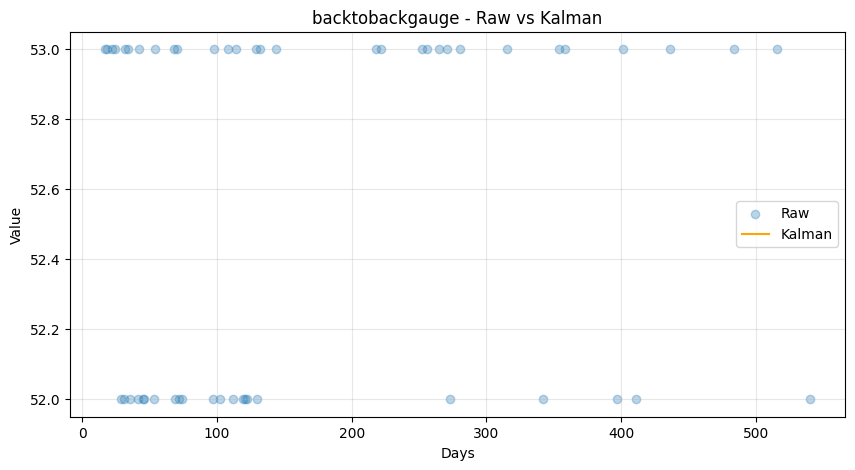

In [15]:
import matplotlib.pyplot as plt
temp = full_wpd[(full_wpd['equipmentnumber'] == 1) & (full_wpd['axle'] == 1) & (full_wpd['side'] == 'L')]['applieddate'].unique()
temp = full_wpd[(full_wpd['equipmentnumber'] == 1) & (full_wpd['axle'] == 1) & (full_wpd['side'] == 'L') & (full_wpd['applieddate'] == temp[1])]
# make sure we have days (if not already in full_wpd)
if "days" not in temp.columns:
    temp["days"] = (temp["traindate"] - temp["traindate"].min()).dt.days

signal = "kalman"
# find all features that have a lowpass
features = [c.replace(f"_{signal}", "") for c in temp.columns if c.endswith(f"_{signal}")]

for feat in features:
    raw_col   = f"{feat}"
    signal_col    = f"{feat}_{signal}"

    if raw_col not in temp or signal_col not in temp:
        continue

    plt.figure(figsize=(10, 5))
    plt.scatter(temp["days"], temp[raw_col], label="Raw", alpha=0.3)
    plt.plot(temp["days"], temp[signal_col], color='orange', label=signal.capitalize())

    plt.title(f"{feat} - Raw vs {signal.capitalize()}")
    plt.xlabel("Days")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    break
